In [1]:
from haystack.dataclasses import ChatMessage
from haystack.components.generators.chat import OpenAIChatGenerator

# 建立系統消息和用戶消息的 ChatMessage 對象
# 系統消息提示生成的回應應該始終使用繁體中文，即使輸入是其他語言
# 用戶消息則是提問 "什麼是自然語言處理？要簡潔。"。
messages = [
    ChatMessage.from_system(
        "即使某些輸入資料採用其他語言，也始終以繁體中文回應。"
    ),
    ChatMessage.from_user(
        "什麼是自然語言處理？要簡潔。"
    ),
]

# 初始化 OpenAIChatGenerator
chat_generator = OpenAIChatGenerator(model="gpt-4-turbo")
# 傳入消息並運行生成對話
response = chat_generator.run(messages=messages)
# 輸出查看
print(response)

/Users/samhsiao/Documents/PythonVenv/envHaystack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'replies': [ChatMessage(content='自然語言處理（NLP）是一門計算機科學、人工智慧和語言學的交叉學科，主要處理人與電腦之間使用自然語言進行有效溝通的方式。其技術包括語言理解、語言生成、和語音識別等，旨在幫助機器理解和生成人類語言。', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-4-turbo-2024-04-09', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 126, 'prompt_tokens': 71, 'total_tokens': 197}})]}


In [2]:
from haystack.dataclasses import ChatMessage
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.generators.utils import print_streaming_chunk

# 使用流式回調函數初始化 OpenAIChatGenerator
chat_generator = OpenAIChatGenerator(
    model="gpt-4-turbo",
    streaming_callback=print_streaming_chunk
)
# 傳入消息並運行
response = chat_generator.run(messages=messages)

自然語言處理（NLP）是一門計算機科學和人工智能的分支，致力於使計算機能夠理解、解釋和生成人類語言的方法和技術。通过这些技术，计算机可以执行语言翻译、情感分析、语音识别和其他与语言相关的任务。

保存 OpenAI API Key 為環境變量

In [3]:
from getpass import getpass
import os
from dotenv import load_dotenv

# 載入環境變數
load_dotenv()
# 兩個 API 的密鑰
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

In [4]:
from haystack import Pipeline, Document
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.writers import DocumentWriter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder

In [5]:
# 建立文件
documents = [
    Document(content="My name is Jean and I live in Paris."),
    Document(content="My name is Mark and I live in Berlin."),
    Document(content="My name is Giorgio and I live in Rome."),
    Document(content="My name is Marta and I live in Madrid."),
    Document(content="My name is Harry and I live in London."),
]

In [6]:
# 建立索引管道
indexing_pipeline = Pipeline()

In [7]:
# 初始化內存文件儲存組件
document_store = InMemoryDocumentStore()    
# 在管道中加入組件：將文件內容轉換成嵌入向量
indexing_pipeline.add_component(
    instance=SentenceTransformersDocumentEmbedder(
        model="sentence-transformers/all-MiniLM-L6-v2"
    ),
    name="doc_embedder"
)
# 加入組件：將處理後的文件數據寫入到指定的文件存儲
# 指定使用 `內存文件儲存`
indexing_pipeline.add_component(
    instance=DocumentWriter(document_store=document_store),
    name="doc_writer"
)

In [8]:
# 連接嵌入器和文件寫入器
indexing_pipeline.connect(
    "doc_embedder.documents",
    "doc_writer.documents"
)

🚅 Components
  - doc_embedder: SentenceTransformersDocumentEmbedder
  - doc_writer: DocumentWriter
🛤️ Connections
  - doc_embedder.documents -> doc_writer.documents (List[Document])

In [9]:
# 運行管道
indexing_pipeline.run({
    "doc_embedder": {"documents": documents}
})

/Users/samhsiao/Documents/PythonVenv/envHaystack/lib/python3.10/site-packages/sentence_transformers/SentenceTransformer.py:174: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v3 of SentenceTransformers.
  warnings.warn(
/Users/samhsiao/Documents/PythonVenv/envHaystack/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


{'doc_writer': {'documents_written': 5}}

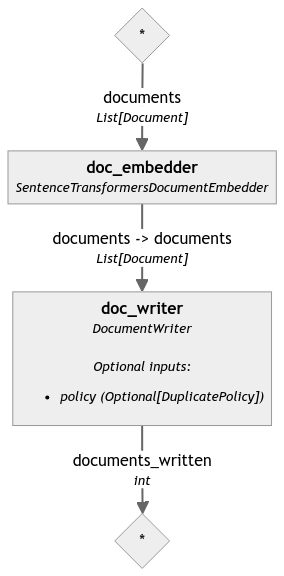

In [10]:
from utils.draw_pipeline import draw_and_display

draw_and_display(indexing_pipeline, "ex10_1_pipe.png")

In [11]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator

In [12]:
# 定義提示模板
template = """
根據給定的上下文回答問題。

上下文:
{% for document in documents %}
    {{ document.content }}
{% endfor %}
問題: {{ question }}
答案:
"""

In [13]:
# 建立 RAG 管道
rag_pipe = Pipeline()

In [14]:
rag_pipe.add_component(
    "embedder",
    SentenceTransformersTextEmbedder(
        model="sentence-transformers/all-MiniLM-L6-v2"
    )
)
rag_pipe.add_component(
    "retriever",
    InMemoryEmbeddingRetriever(
        document_store=document_store
    )
)
rag_pipe.add_component(
    "prompt_builder",
    PromptBuilder(
        template=template
    )
)
rag_pipe.add_component(
    "llm",
    OpenAIGenerator(model="gpt-4-turbo")
)

In [15]:
# 連接組件
rag_pipe.connect(
    "embedder.embedding",
    "retriever.query_embedding"
)
rag_pipe.connect(
    "retriever",
    "prompt_builder.documents"
)
rag_pipe.connect(
    "prompt_builder",
    "llm"
)

🚅 Components
  - embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

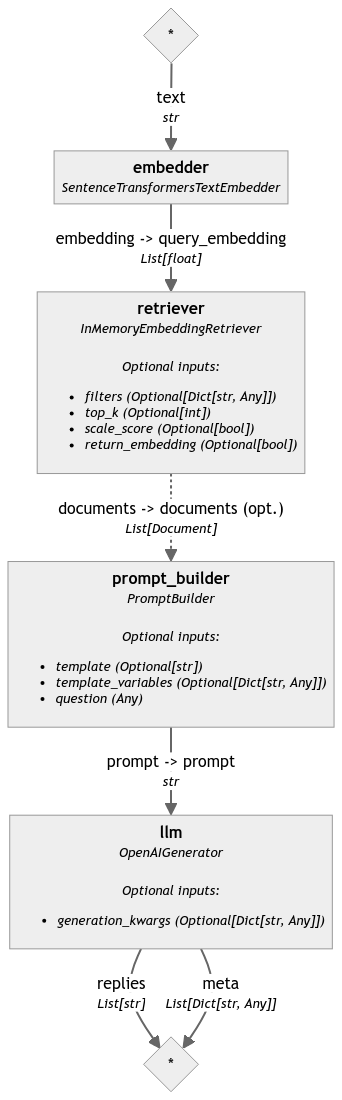

In [16]:
draw_and_display(rag_pipe, "ex10_2_pipe.png")